In [107]:

import torch
from torch.utils.data import DataLoader
from model import BERT, BERTPrediction
from dataset import LandsatDataLoader
import logging
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import random

torch.manual_seed(0)
random.seed(0)

In [108]:

def load_model(checkpoint_path: str, model: BERTPrediction, num_features: int) -> BERTPrediction:
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [109]:

def sample_data(val_loader: DataLoader, num_samples: int = 10) -> list:
    samples = []
    for i, data in enumerate(val_loader):
        if i >= num_samples:
            break
        samples.append(data)
    return samples


In [110]:
def evaluate_model(model: BERTPrediction, samples: list) -> None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = torch.nn.MSELoss(reduction="mean")
    mae_criterion = torch.nn.L1Loss(reduction="mean")

    for i, (inputs, targets) in enumerate(samples):
        x, year_seq = inputs.split(1, dim=-1)
        year_seq = year_seq.squeeze(-1)
        x = x.to(device)
        year_seq = year_seq.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = model(x, year_seq)
            y = targets[:, 0]
            # handle both batched and non-batched outputs
            if outputs.dim() > 1 and outputs.size(1) > 1:
                outputs = outputs[:, 0]
            loss = criterion(y, outputs)
            mae = mae_criterion(y, outputs)

        print(f"Sample {i+1}:")
        # print(f"  X: {x.cpu().numpy()}")
        print(f"  True Value: {y.cpu().numpy()}")
        print(f"  Predicted Value: {outputs.cpu().numpy()}")
        print(f"  MSE Loss: {loss.item()}")
        print(f"  MAE: {mae.item()}")
        print()

In [111]:
def create_outputs(model: BERTPrediction, samples: list) -> list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    outputs_list = []

    for inputs, targets in samples:
        x, year_seq = inputs.split(1, dim=-1)
        year_seq = year_seq.squeeze(-1)
        x = x.to(device)
        year_seq = year_seq.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = model(x, year_seq)
            y = targets[:, 0]
            if outputs.dim() > 1 and outputs.size(1) > 1:
                outputs = outputs[:, 0]

        out_year_seq = targets[:, 1]
        outputs_list.append((x.cpu().numpy().flatten(), year_seq.cpu().numpy().flatten(), y.cpu().numpy().flatten(), out_year_seq.cpu().numpy().flatten(), outputs.cpu().numpy().flatten()))

    return outputs_list


def plot_outputs(outputs_list: list, plots_per_row: int = 2) -> None:
    num_samples = len(outputs_list)
    num_rows = (num_samples + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, (x, year_seq, y, out_year_seq, outputs) in enumerate(outputs_list):
        ax = axes[i]
        
        # Plot input values
        ax.plot(year_seq, x, 'g.', label='Input Values')
        ax.plot(year_seq, x, 'g-')

        # Create a new line segment to connect X to Y
        # connection_x = [year_seq[-1], out_year_seq[0]]
        # connection_y = [x[-1], y[0]]
        # ax.plot(connection_x, connection_y, 'b-', linewidth=2, label='Connection')
        
        # Plot true values and predicted values
        ax.plot(out_year_seq, y, 'b.', label='True Value')
        ax.plot(out_year_seq, y, 'b-')
        ax.plot(out_year_seq, outputs, 'r.', label='Predicted Value')
        ax.plot(out_year_seq, outputs, 'r-')
        
        ax.set_xlabel('Year')
        ax.set_ylabel('NDVI')
        ax.set_ylim(0, 1)
        ax.set_title(f'Sample {i+1}')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_predictions(model: BERTPrediction, samples: list, plots_per_row: int = 2) -> None:
    outputs_list = create_outputs(model, samples)
    plot_outputs(outputs_list, plots_per_row)


In [112]:

experiment = "24-08-24_19-44_L2_200e"

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO, datefmt="%Y-%m-%d %H:%M:%S")

logging.info("Loading validation dataset...")
batch_size = 1
split_rate = 0.1
num_workers = 8
window_size = 5
loader = LandsatDataLoader("../data/Landsat_NDVI_time_series_1984_to_2024.tif", batch_size, split_rate, num_workers, window_size)
_, val_loader = loader.create_data_loaders()

logging.info("Creating model...")
bert = BERT(num_features=1, hidden=256, n_layers=3, attn_heads=8, dropout=0.1)
model = BERTPrediction(bert, 1)

logging.info("Loading model...")
checkpoint_path = os.path.join("..", "runs", experiment, "checkpoint.tar")
model = load_model(checkpoint_path, model, 1)

logging.info("Sampling data...")
samples = sample_data(val_loader)

2024-08-25 00:09:14 - Loading validation dataset...
2024-08-25 00:09:14 - Loading pre-processed data...
2024-08-25 00:09:36 - Loaded data shapes - Input: torch.Size([172365270, 5, 2]), Output: torch.Size([172365270, 2]), Window size: 5
2024-08-25 00:09:36 - Pre-processed data loaded successfully.
2024-08-25 00:09:36 - Creating data loaders with batch_size: 1, split_rate: 0.1, num_workers: 8
2024-08-25 00:09:36 - Dataset split started with 172365270 samples
2024-08-25 00:09:56 - Dataset split completed
2024-08-25 00:09:56 - Dataset split: 17236527 training samples, 155128743 validation samples
2024-08-25 00:09:56 - Creating train loader...
2024-08-25 00:09:56 - Train loader created
2024-08-25 00:09:56 - Creating validation loader...
2024-08-25 00:09:56 - Validation loader created
2024-08-25 00:09:56 - Data loaders created successfully
2024-08-25 00:10:00 - Creating model...
/home/ido/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tens

In [113]:
logging.info("Evaluating model...")
evaluate_model(model, samples)

2024-08-25 00:10:03 - Evaluating model...


Sample 1:
  True Value: [0.29455394]
  Predicted Value: [0.3317192]
  MSE Loss: 0.0013812561519443989
  MAE: 0.03716525435447693

Sample 2:
  True Value: [0.2692837]
  Predicted Value: [0.33308825]
  MSE Loss: 0.004071019124239683
  MAE: 0.06380453705787659

Sample 3:
  True Value: [0.22522111]
  Predicted Value: [0.17318118]
  MSE Loss: 0.0027081549633294344
  MAE: 0.05203993618488312

Sample 4:
  True Value: [0.16724437]
  Predicted Value: [0.16099425]
  MSE Loss: 3.9064103475539014e-05
  MAE: 0.006250128149986267

Sample 5:
  True Value: [0.25145602]
  Predicted Value: [0.23289451]
  MSE Loss: 0.00034452974796295166
  MAE: 0.018561512231826782

Sample 6:
  True Value: [0.2121754]
  Predicted Value: [0.15251708]
  MSE Loss: 0.003559115109965205
  MAE: 0.059658318758010864

Sample 7:
  True Value: [-0.24784452]
  Predicted Value: [-0.12502772]
  MSE Loss: 0.01508396677672863
  MAE: 0.12281680107116699

Sample 8:
  True Value: [0.14157195]
  Predicted Value: [0.13587376]
  MSE Loss: 3.

2024-08-25 00:10:03 - Plotting predictions...


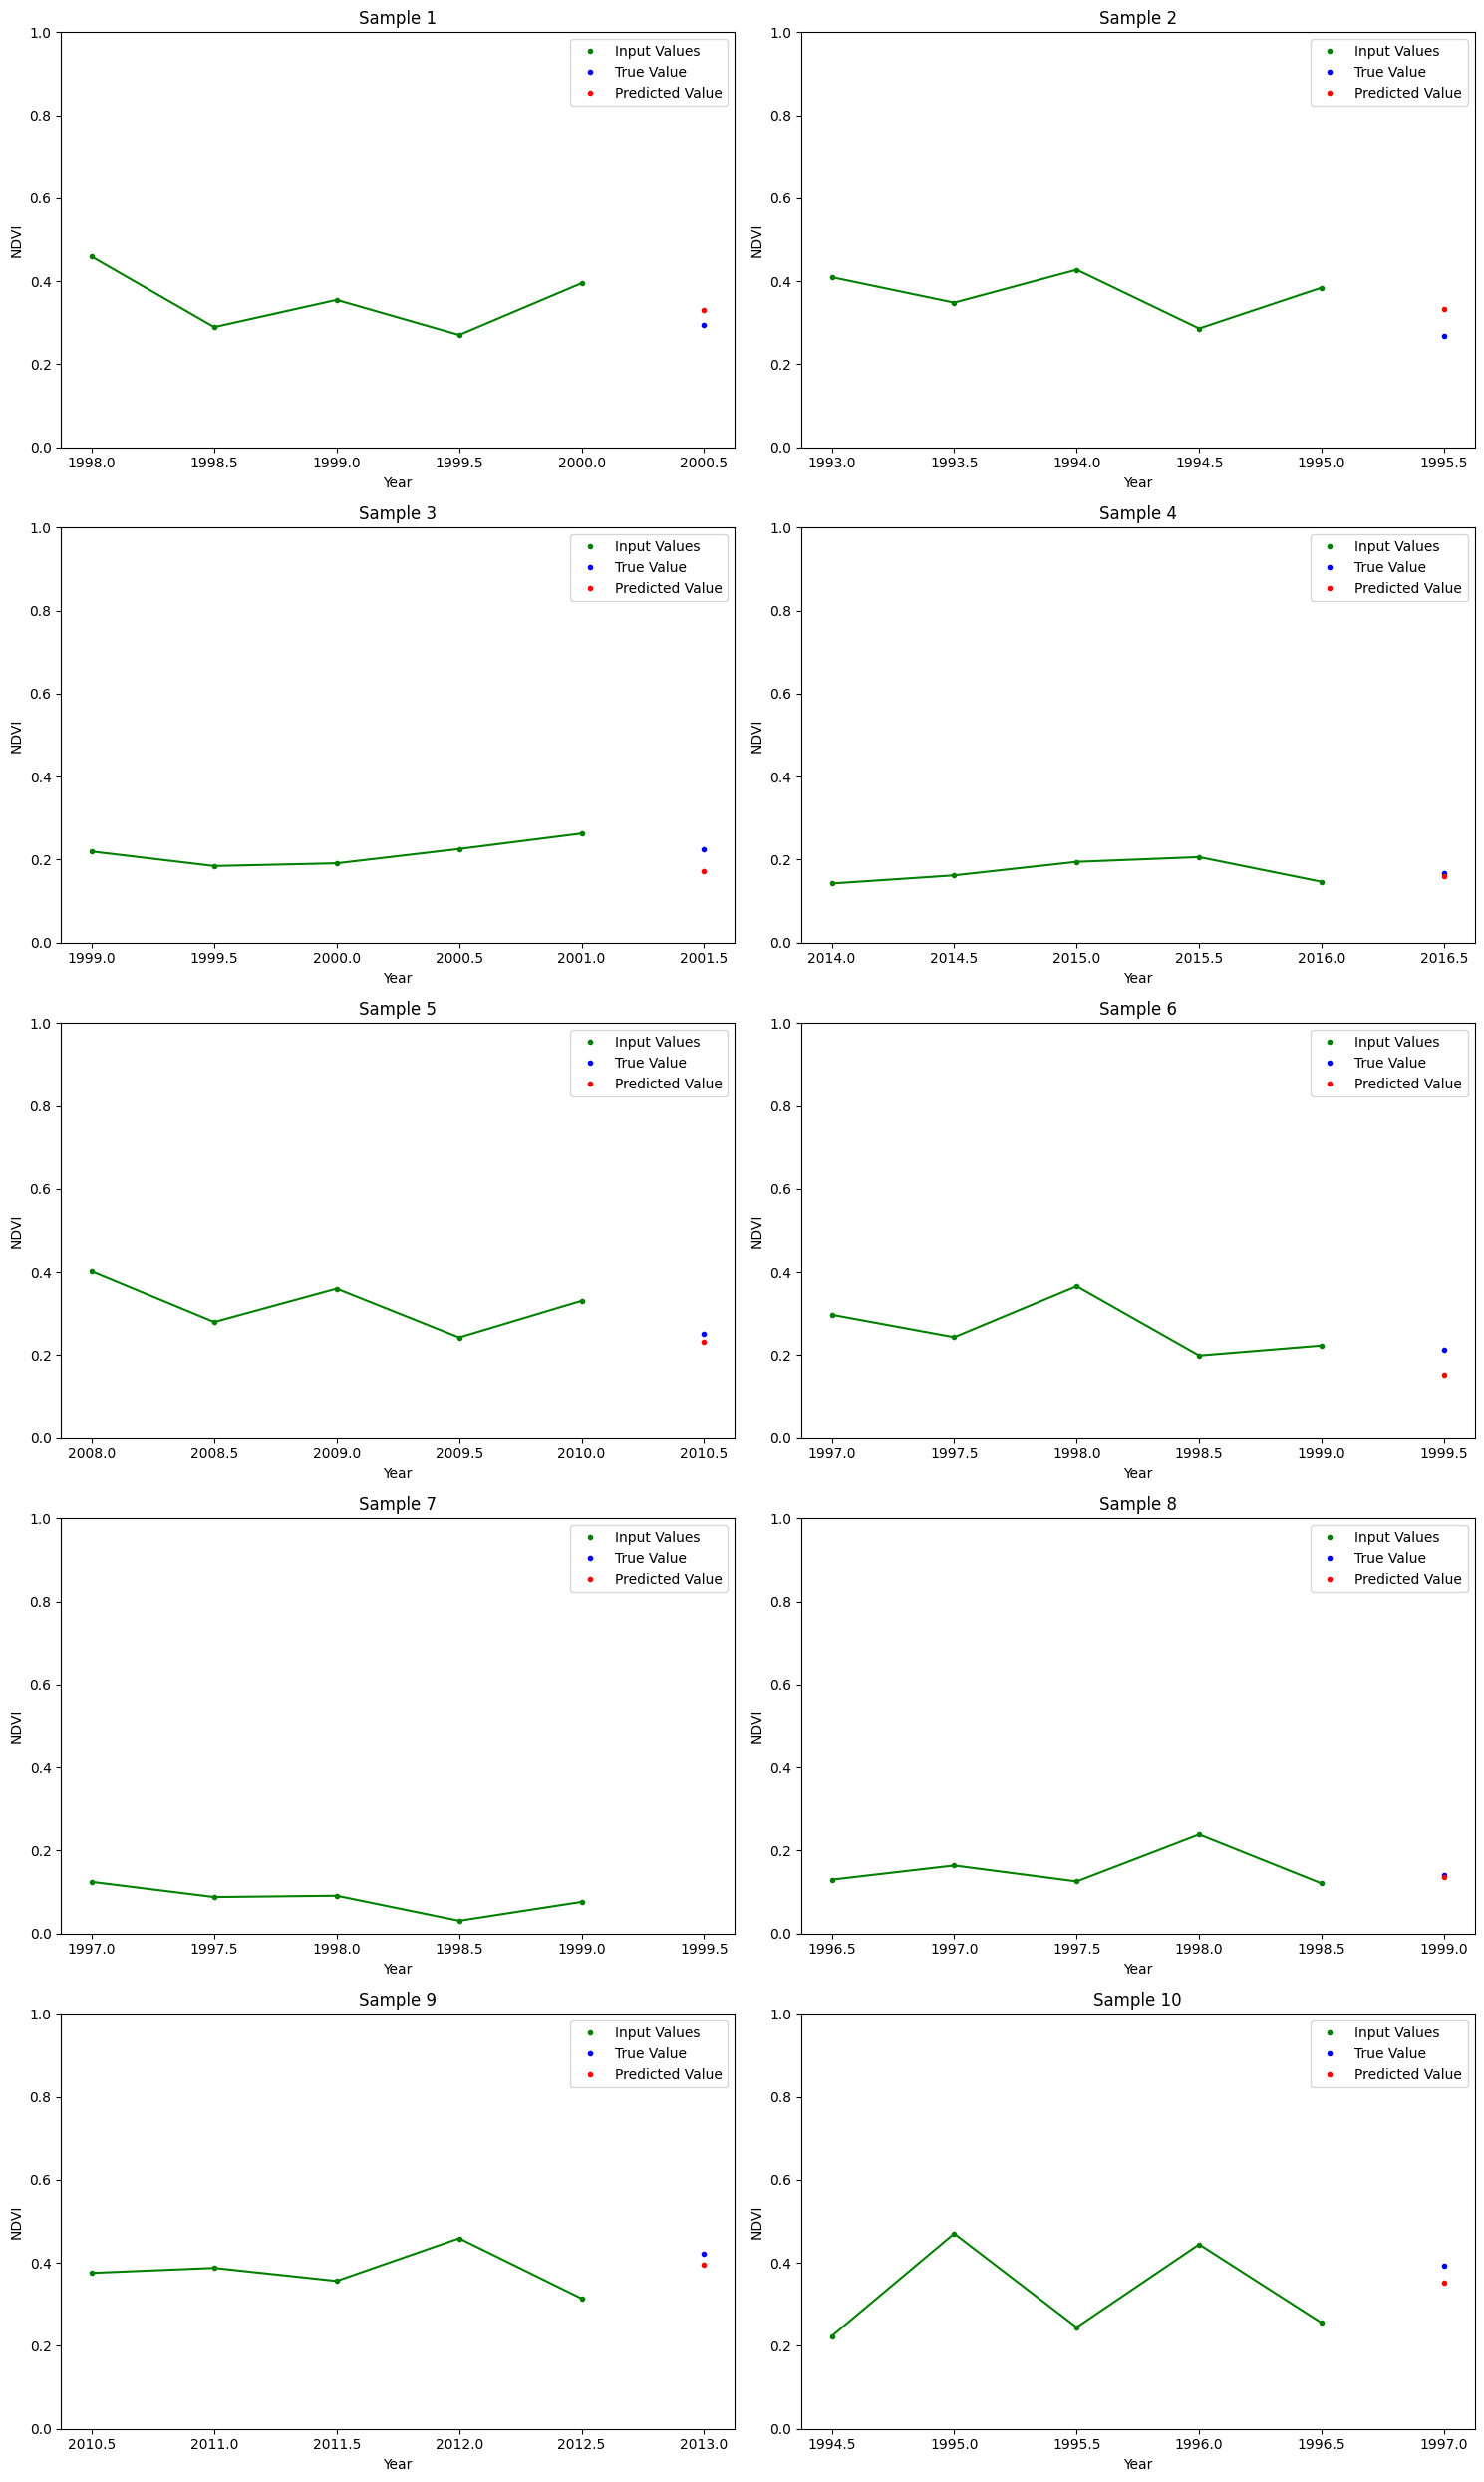

In [114]:
logging.info("Plotting predictions...")
plot_predictions(model, samples)

In [115]:
# load full data
from dataset.landsat_ts import LandsatSpectralDataset

with rasterio.open("../data/Landsat_NDVI_time_series_1984_to_2024.tif") as src:
    ndvi_data: np.ndarray = src.read()
    band_names = src.descriptions
    logging.info(f"Original NDVI data shape: {ndvi_data.shape}")

# Extracting year information from band names
year_info = LandsatSpectralDataset.extract_year_info(band_names)
logging.info(f"Year information extracted: {year_info}")

ndvi_year_data = LandsatSpectralDataset.combine_ndvi_with_year(ndvi_data, year_info)
# restore original spatial dimensions
ndvi_year_data = ndvi_year_data.reshape(*ndvi_data.shape, 2)
logging.info(f"NDVI-Year data shape: {ndvi_year_data.shape}")

2024-08-25 00:10:07 - Original NDVI data shape: (82, 1798, 1245)
2024-08-25 00:10:07 - Year information extracted: {0: 1984, 1: 1984.5, 2: 1985, 3: 1985.5, 4: 1986, 5: 1986.5, 6: 1987, 7: 1987.5, 8: 1988, 9: 1988.5, 10: 1989, 11: 1989.5, 12: 1990, 13: 1990.5, 14: 1991, 15: 1991.5, 16: 1992, 17: 1992.5, 18: 1993, 19: 1993.5, 20: 1994, 21: 1994.5, 22: 1995, 23: 1995.5, 24: 1996, 25: 1996.5, 26: 1997, 27: 1997.5, 28: 1998, 29: 1998.5, 30: 1999, 31: 1999.5, 32: 2000, 33: 2000.5, 34: 2001, 35: 2001.5, 36: 2002, 37: 2002.5, 38: 2003, 39: 2003.5, 40: 2004, 41: 2004.5, 42: 2005, 43: 2005.5, 44: 2006, 45: 2006.5, 46: 2007, 47: 2007.5, 48: 2008, 49: 2008.5, 50: 2009, 51: 2009.5, 52: 2010, 53: 2010.5, 54: 2011, 55: 2011.5, 56: 2012, 57: 2012.5, 58: 2013, 59: 2013.5, 60: 2014, 61: 2014.5, 62: 2015, 63: 2015.5, 64: 2016, 65: 2016.5, 66: 2017, 67: 2017.5, 68: 2018, 69: 2018.5, 70: 2019, 71: 2019.5, 72: 2020, 73: 2020.5, 74: 2021, 75: 2021.5, 76: 2022, 77: 2022.5, 78: 2023, 79: 2023.5, 80: 2024, 81: 

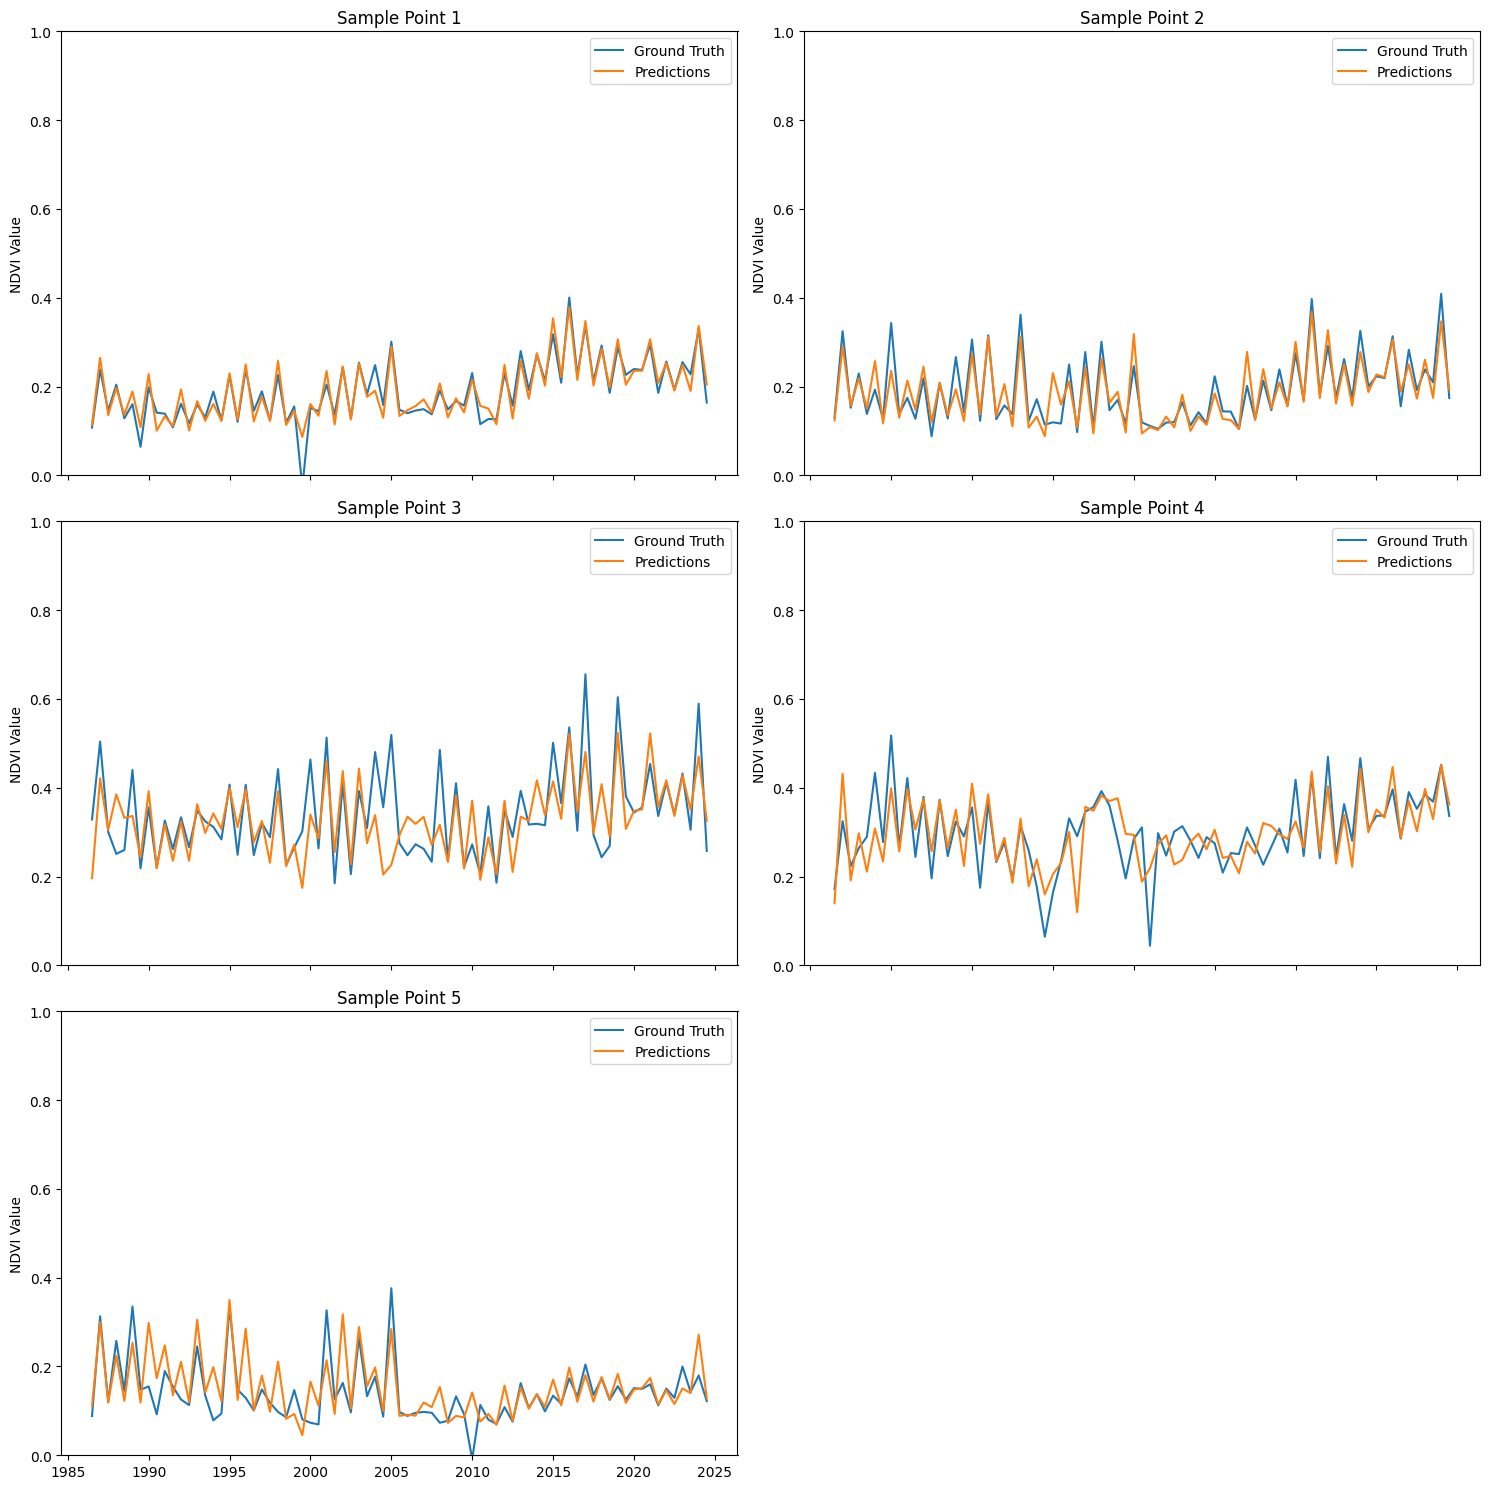

In [116]:
def sample_data(ndvi_year_data, num_samples):
    ndvi_year_data_reshaped = ndvi_year_data.reshape(ndvi_year_data.shape[0], -1, 2)
    sampled_indices = random.sample(range(ndvi_year_data_reshaped.shape[1]), num_samples)
    sampled_points = ndvi_year_data_reshaped[:, sampled_indices, :]
    return sampled_points

def generate_predictions(model, point, window_size, device):
    predictions = []
    ground_truth = []
    years = []

    for i in range(len(point) - window_size):
        input_seq = point[i:i + window_size]
        true_value = point[i + window_size, 0]  # NDVI value at the next time step
        year_value = point[i + window_size, 1]  # Year value at the next time step

        # Prepare input for the model
        x = torch.FloatTensor(input_seq[:, 0]).unsqueeze(0).unsqueeze(-1)  # NDVI values
        year_seq = torch.FloatTensor(input_seq[:, 1]).unsqueeze(0)  # Year values

        # Move to device
        x = x.to(device)
        year_seq = year_seq.to(device)

        # Get model prediction
        with torch.no_grad():
            predicted_value = model(x, year_seq).cpu().numpy().flatten()[0]

        # Store predictions, ground truth, and years
        predictions.append(predicted_value)
        ground_truth.append(true_value)
        years.append(year_value)

    return predictions, ground_truth, years

def visualize_predictions(predictions_list, ground_truth_list, years_list, graphs_per_row):
    num_samples = len(predictions_list)
    num_rows = (num_samples + graphs_per_row - 1) // graphs_per_row  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, (predictions, ground_truth, years) in enumerate(zip(predictions_list, ground_truth_list, years_list)):
        axes[idx].plot(years, ground_truth, label='Ground Truth')
        axes[idx].plot(years, predictions, label='Predictions')
        axes[idx].set_ylabel('NDVI Value')
        axes[idx].set_title(f'Sample Point {idx + 1}')
        axes[idx].legend()
        axes[idx].set_ylim(0, 1)  # Set y-axis scale to 0..1

    for ax in axes[num_samples:]:  # Hide any unused subplots
        ax.axis('off')

    axes[-1].set_xlabel('Year')
    plt.tight_layout()
    plt.show()

# Sample 5 points based on spatial dimension 1:2
num_samples = 5
sampled_points = sample_data(ndvi_year_data, num_samples)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Store predictions, ground truth, and years for all sampled points
predictions_list = []
ground_truth_list = []
years_list = []

# Iterate over each sampled point
for idx, point in enumerate(sampled_points.transpose(1, 0, 2)):
    predictions, ground_truth, years = generate_predictions(model, point, window_size, device)
    predictions_list.append(predictions)
    ground_truth_list.append(ground_truth)
    years_list.append(years)

# Visualize all sampled points on the same image split into 5 graphs
graphs_per_row = 2  # Control how many graphs per row
visualize_predictions(predictions_list, ground_truth_list, years_list, graphs_per_row)